In [1]:
import os,sys
import numpy as np
import pandas as pd
from tqdm import tqdm
import cPickle as pk
np.random.seed(1) # to be reproductive

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model

Using TensorFlow backend.


In [2]:
# paths
NOTE_DATA_DIR = '/local/XW/DATA/MIMIC/noteevents_by_sid/'
ICD_FPATH = './subject_icds.txt'
# constants
N_LABELS = 40
K_ICDS_TOKEEP = N_LABELS - 1 # predict only on top K frequent icd codes
N_SUBJECTS = 41886
# word2vec configurations
GLOVE_DIR = '/local/XW/DATA/glove.6B/'
MAX_SEQ_LEN = 1000
MAX_NB_WORDS = 20000 # top 20k most freq words
EMBEDDING_DIM = 100
# learning configurations
VALIDATION_SPLIT = 0.2
N_EPOCHS = 10
SZ_BATCH = 128

# 1. Data preparation

## prepare label: k-hot encoding for icd code 

In [3]:
# load the icd code into a defaultdict
from collections import Counter
sid2icds = {} # map subject_id ---> icd codes of this patient
icd_ctr = Counter()
with open(ICD_FPATH) as f: 
    for line in tqdm(f, total=N_SUBJECTS): 
        codes = map(int, line.split())
        sid, _icds = codes[0], codes[1:]
        icd_ctr.update(_icds)
        sid2icds[sid] = set(_icds)
#         print sid, icd[sid]

100%|██████████| 41886/41886 [00:00<00:00, 100579.90it/s]


In [4]:
print icd_ctr.most_common(K_ICDS_TOKEEP)

[(3893, 14631), (9604, 10234), (966, 9245), (9671, 8983), (9904, 7235), (3961, 6831), (9672, 5973), (9955, 5748), (8856, 5324), (3891, 4669), (3615, 4397), (9915, 4228), (8872, 3536), (3722, 3306), (3995, 3235), (3324, 3222), (4513, 2911), (9390, 2721), (3723, 2702), (9983, 2391), (5491, 2209), (331, 2198), (8853, 2112), (640, 2084), (9907, 2026), (3612, 1901), (3491, 1825), (3895, 1812), (311, 1768), (9920, 1737), (3404, 1705), (3897, 1667), (40, 1646), (8841, 1564), (4311, 1530), (3613, 1502), (3521, 1419), (66, 1321), (3606, 1255)]


In [7]:
icds = zip( *icd_ctr.most_common(K_ICDS_TOKEEP) )[0] + ('other',)
print icds # these are icds to predict

(3893, 9604, 966, 9671, 9904, 3961, 9672, 9955, 8856, 3891, 3615, 9915, 8872, 3722, 3995, 3324, 4513, 9390, 3723, 9983, 5491, 331, 8853, 640, 9907, 3612, 3491, 3895, 311, 9920, 3404, 3897, 40, 8841, 4311, 3613, 3521, 66, 3606, 'other')


In [8]:
# now turn each subject into a k-hot vector
sid2khot = {} # map subject_id to k-hot vector

for sid in sid2icds.keys():
    _khot = np.zeros(N_LABELS)
    for _icd in sid2icds[sid]:
        if _icd in icds: 
            _khot[icds.index(_icd)] = 1
        else: # label 'other icds'
            _khot[-1] = 1
    sid2khot[sid] = _khot

print np.array( [sid2khot[i] for i in [2,3]] )

    

[[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.]
 [ 1.  1.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  1.]]


In [9]:
# Y = np.zeros( (N_SUBJECTS, N_LABELS) )
# for i,sid in enumerate(sorted(sid2icds.keys())):
#     for _icd in sid2icds[sid]:
#         if _icd in icds: 
#             Y[i,icds.index(_icd)] = 1
#         else: # label 'other icds'
#             Y[i, -1] = 1
# # a small check
# print sid2icds.items()[:2]
# print icds
# print Y[:2,]

## prepare `X`: each note to be a (fixe-length) sequence of word ids

In [10]:
# prepare text
texts = [] # text bodies
labels = [] # k-hot labels
for fname in tqdm(os.listdir(NOTE_DATA_DIR)): # the data is 3.7G in size, can be hold in memory...
    sid = int(fname[:-4]) 
    labels.append(sid2khot[sid])
    fpath = os.path.join(NOTE_DATA_DIR, fname)
    df = pd.read_csv(fpath)
    texts.append( '\n=======\n\n\n'.join(df['text']) )
print('found %d texts' % len(texts))

100%|██████████| 41886/41886 [01:24<00:00, 496.91it/s]

found 41886 texts


**Now vectorize the notes**

In [ ]:
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS, # filter out numbers, otherwise lots of numbers
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'+'0123456789') 
tokenizer.fit_on_texts(texts) # this is required before using `texts_to_sequences`, might take time
seqs = tokenizer.texts_to_sequences(texts) # turn article into list of ids
word_index = tokenizer.word_index # dictionary mapping words (str) to their index (int)

** let's do some stat on seq length**

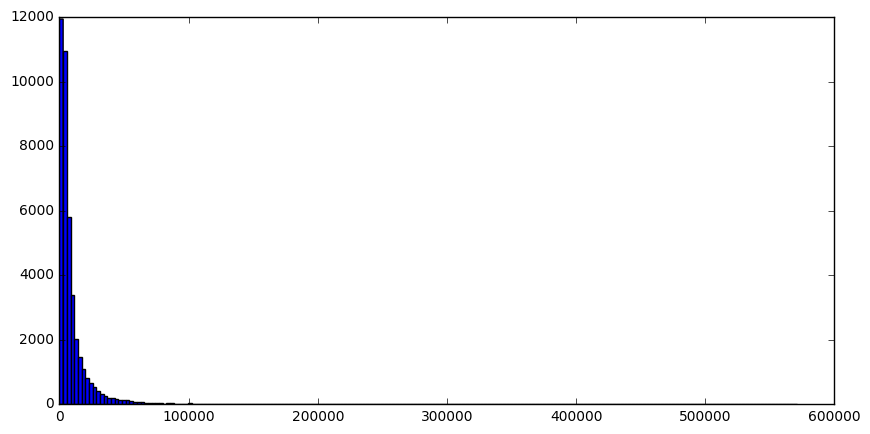

In [10]:
seqlen = map(len, seqs)
import matplotlib.pyplot as plt
%matplotlib inline 
import pylab
pylab.rcParams['figure.figsize'] = (10, 5)
h = plt.hist(seqlen, bins=200)

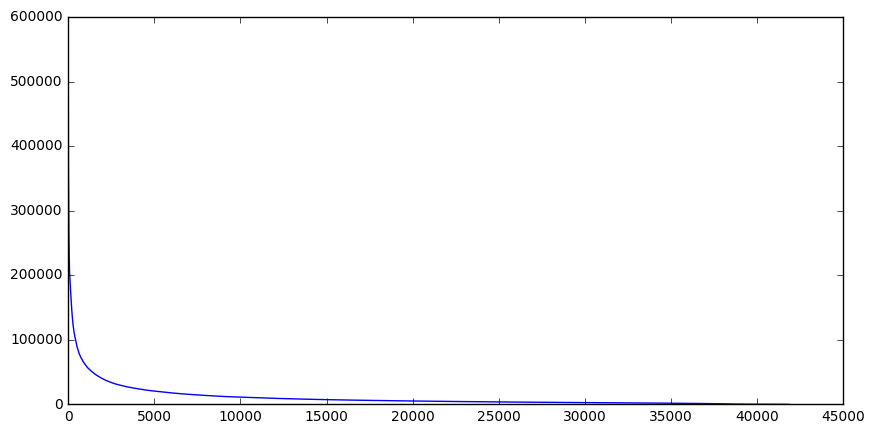

In [11]:
plt.plot(sorted(seqlen, reverse=True))

So set MAX_SEQ_LENGTH=1000 should make sense..

In [12]:
# for seq in seqs[:2]:
#     print seq
#     print '======'

print 'found %s unique tokens, use most frequent %d of them'%(len(word_index), MAX_NB_WORDS)

found 363215 unique tokens, use most frequent 20000 of them


In [13]:
print sorted(word_index.items(), key=lambda (k,v): v)[:100] # TODO: remove stopwords

[('and', 1), ('to', 2), ('the', 3), ('of', 4), ('with', 5), ('for', 6), ('in', 7), ('no', 8), ('is', 9), ('on', 10), ('a', 11), ('was', 12), ('pt', 13), ('at', 14), ('am', 15), ('name', 16), ('s', 17), ('mg', 18), ('o', 19), ('left', 20), ('this', 21), ('as', 22), ('right', 23), ('ml', 24), ('patient', 25), ('pm', 26), ('p', 27), ('l', 28), ('last', 29), ('there', 30), ('not', 31), ('are', 32), ('or', 33), ('w', 34), ('from', 35), ('c', 36), ('chest', 37), ('plan', 38), ('normal', 39), ('hr', 40), ('po', 41), ('reason', 42), ('t', 43), ('clip', 44), ('pain', 45), ('dl', 46), ('be', 47), ('d', 48), ('has', 49), ('ct', 50), ('continue', 51), ('he', 52), ('cc', 53), ('blood', 54), ('assessment', 55), ('x', 56), ('location', 57), ('status', 58), ('by', 59), ('stable', 60), ('day', 61), ('but', 62), ('year', 63), ('noted', 64), ('tube', 65), ('she', 66), ('well', 67), ('history', 68), ('hospital', 69), ('given', 70), ('contrast', 71), ('will', 72), ('old', 73), ('iv', 74), ('cont', 75), ('e

In [14]:
data = pad_sequences(seqs, maxlen=MAX_SEQ_LEN)
labels = np.array(labels)

In [15]:
print('shape of data tensor:', data.shape)
print('shape of label tensor:', labels.shape)

('shape of data tensor:', (41886, 1000))
('shape of label tensor:', (41886, 40))


## Split training and testing data

In [16]:
# split data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data, labels = data[indices], labels[indices]
validset_sz = int(VALIDATION_SPLIT*data.shape[0])

X_train, Y_train = data[:-validset_sz], labels[:-validset_sz]
X_val, Y_val = data[-validset_sz:], labels[-validset_sz:]

## Prepare embedding matrix(vector of each wd in dictionary)

In [17]:
# build index mapping: map word to its vector

word2vec = {} # maps word ---> embedding vector
with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt')) as f:
    for line in tqdm(f, total=400000):
        vals = line.split()
        word = vals[0]
        word2vec[word] = np.asarray(vals[1:], dtype='float')
print 'found %d word vectors.' % len(word2vec)

100%|██████████| 400000/400000 [00:07<00:00, 53447.82it/s]

found 400000 word vectors.


In [18]:
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros( (nb_words+1, EMBEDDING_DIM) ) # +1 because ids in sequences starts from 1 ?
for word,wd_id in tqdm(word_index.items()): 
    if wd_id > MAX_NB_WORDS or word not in word2vec: # there might be 0 rows in embedding matrix
        continue # word_id>MAX_NB_WORDS, this id is not in the generated sequences, discard
    embedding_matrix[wd_id,:] = word2vec[word]

100%|██████████| 363215/363215 [00:00<00:00, 2098307.41it/s]


---

# 2. Model training

In [19]:
from keras.models import Sequential

In [20]:
model = Sequential([
        Embedding(input_dim=nb_words+1,output_dim=EMBEDDING_DIM, weights=[embedding_matrix],
          input_length=MAX_SEQ_LEN, trainable=False #keep the embeddings fixed
         ),# embedding layer
        Conv1D(128, 5, activation='relu'),
        MaxPooling1D(5),
        Conv1D(128, 5, activation='relu'),
        MaxPooling1D(5),
        Flatten(),
        Dense(N_LABELS, activation='softmax') # candidate: sigmoid/tanh?
    ])


In [21]:
# define our own metrics 

import keras.backend as K

def relax_acc(y_true, y_pred): # shape: (None,N_LABELS)
    '''relaxed accuracy for the case when y_true is K-hot 
    if the predicted icd code is in the patient's icds, then it's good
    
    **note:**
    the y_pred is the softmax output, we need to make it into 1-hot encoding 
    * via K.round() -- doesn't work well , lots of 0s
    * by hand -- doesn't work either: 
    >InvalidArgumentError: You must feed a value for placeholder tensor 'embedding_input_4' with dtype int32
    
    ==> so the output is not the accuracy as we defined, but a *continus relaxation* version...
    '''
#     y_pred =K.round(y_pred) # doesn't work well, lots of 0s

#     onehot = np.zeros_like(y_pred)
#     onehot[:, K.eval(K.argmax(y_pred, axis=1))] = 1.0
#     import tensorflow as tf
#     y_pred = tf.constant(onehot)
    
#     idx = range(K.int_shape(y_pred)[0])
#     K.equal( y_true[idx,K.argmax(y_pred, axis=1)],
#             K.ones_like(idx) )

    
    y_int = y_pred * y_true # element-wise mul, intersection
    return K.mean( K.sum(y_int, axis=-1) )

# TODO: custom loss function suitable for multi-label senarios ??
# example: element-wise mul of softmax and y_true ? 

model.compile(loss='categorical_crossentropy',
             optimizer='rmsprop',
             metrics=[relax_acc])

In [22]:
model.fit(X_train, Y_train, 
          validation_data=(X_val, Y_val),
          nb_epoch=N_EPOCHS,
          batch_size=SZ_BATCH
         )


Train on 33509 samples, validate on 8377 samples
Epoch 1/10
33509/33509 [==============================] - 587s - loss: 11.4102 - relax_acc: 0.3099 - val_loss: 11.0087 - val_relax_acc: 0.3432
Epoch 2/10
33509/33509 [==============================] - 592s - loss: 10.4760 - relax_acc: 0.3848 - val_loss: 10.4518 - val_relax_acc: 0.4043
Epoch 3/10
33509/33509 [==============================] - 590s - loss: 10.0962 - relax_acc: 0.4203 - val_loss: 10.3279 - val_relax_acc: 0.4277
Epoch 4/10
33509/33509 [==============================] - 593s - loss: 9.8169 - relax_acc: 0.4493 - val_loss: 10.2577 - val_relax_acc: 0.4435
Epoch 5/10
33509/33509 [==============================] - 596s - loss: 9.5505 - relax_acc: 0.4770 - val_loss: 10.2421 - val_relax_acc: 0.4441
Epoch 6/10
33509/33509 [==============================] - 596s - loss: 9.2863 - relax_acc: 0.5055 - val_loss: 10.5523 - val_relax_acc: 0.5039
Epoch 7/10
33509/33509 [==============================] - 597s - loss: 9.0282 - relax_acc: 0.535

In [23]:
n_correct = 0
for i,y_pred in tqdm(enumerate(model.predict_classes(X_val))):
    y_true = Y_val[i,:]
    y_true = np.where(y_true==1)[0]
#     print y_pred, y_true, ('correct' if y_pred in y_true else 'wrong')
    if y_pred in y_true: 
        n_correct +=1 

print '%d cases checked, %d correct, accuracy=%.9f' % (X_val.shape[0], n_correct, float(n_correct)/X_val.shape[0] )

8377/8377 [==============================] - 58s    


8377it [00:00, 245121.28it/s]

8377 cases checked, 6148 correct, accuracy=0.733914289


In [24]:
def evaluate_model(model):
    from keras.utils.np_utils import to_categorical
    print K.eval(
        relax_acc(K.variable(Y_val), 
                  K.variable((to_categorical(model.predict_classes(X_val)))) )
        )

In [25]:
# with only 1 conv1d layer
model = Sequential([
        Embedding(input_dim=nb_words+1,output_dim=EMBEDDING_DIM, weights=[embedding_matrix],
          input_length=MAX_SEQ_LEN, trainable=False #keep the embeddings fixed
         ),# embedding layer
        Conv1D(128, 5, activation='relu'),
        MaxPooling1D(5),
        Flatten(),
        Dense(N_LABELS, activation='softmax') # candidate: sigmoid/tanh?
    ])
model.compile(loss='categorical_crossentropy',
             optimizer='rmsprop',
             metrics=[relax_acc])
model.fit(X_train, Y_train, 
          validation_data=(X_val, Y_val),
          nb_epoch=N_EPOCHS,
          batch_size=SZ_BATCH
         )

Train on 33509 samples, validate on 8377 samples
Epoch 1/10
33509/33509 [==============================] - 493s - loss: 12.0296 - relax_acc: 0.3068 - val_loss: 10.7525 - val_relax_acc: 0.3820
Epoch 2/10
33509/33509 [==============================] - 489s - loss: 10.2422 - relax_acc: 0.4098 - val_loss: 10.6882 - val_relax_acc: 0.4061
Epoch 3/10
33509/33509 [==============================] - 489s - loss: 9.5775 - relax_acc: 0.4779 - val_loss: 10.7519 - val_relax_acc: 0.3967
Epoch 4/10
33509/33509 [==============================] - 491s - loss: 9.0290 - relax_acc: 0.5410 - val_loss: 11.0375 - val_relax_acc: 0.4311
Epoch 5/10
33509/33509 [==============================] - 496s - loss: 8.5848 - relax_acc: 0.5959 - val_loss: 11.6918 - val_relax_acc: 0.4913
Epoch 6/10
33509/33509 [==============================] - 493s - loss: 8.2238 - relax_acc: 0.6438 - val_loss: 13.0898 - val_relax_acc: 0.5593
Epoch 7/10
33509/33509 [==============================] - 492s - loss: 7.9526 - relax_acc: 0.6826

In [26]:
evaluate_model(model)

8377/8377 [==============================] - 50s    
0.665871


In [27]:
# a 3-convlayer model
model = Sequential([
        Embedding(input_dim=nb_words+1,output_dim=EMBEDDING_DIM, weights=[embedding_matrix],
          input_length=MAX_SEQ_LEN, trainable=False 
         ),# embedding layer
        Conv1D(128, 5, activation='relu'),
        MaxPooling1D(5),
        Conv1D(128, 5, activation='relu'),
        MaxPooling1D(5),
        Conv1D(128, 5, activation='relu'),
        MaxPooling1D(5),
        Flatten(),
        Dense(N_LABELS, activation='softmax') 
    ])

model.compile(loss='categorical_crossentropy',
             optimizer='rmsprop',
             metrics=[relax_acc])
model.fit(X_train, Y_train, 
          validation_data=(X_val, Y_val),
          nb_epoch=N_EPOCHS,
          batch_size=SZ_BATCH
         )

Train on 33509 samples, validate on 8377 samples
Epoch 1/10
33509/33509 [==============================] - 613s - loss: 11.5490 - relax_acc: 0.2994 - val_loss: 10.9064 - val_relax_acc: 0.3420
Epoch 2/10
33509/33509 [==============================] - 611s - loss: 10.6765 - relax_acc: 0.3678 - val_loss: 10.4984 - val_relax_acc: 0.3623
Epoch 3/10
33509/33509 [==============================] - 607s - loss: 10.2979 - relax_acc: 0.4011 - val_loss: 10.2817 - val_relax_acc: 0.4080
Epoch 4/10
33509/33509 [==============================] - 616s - loss: 10.0537 - relax_acc: 0.4257 - val_loss: 10.2419 - val_relax_acc: 0.4019
Epoch 5/10
33509/33509 [==============================] - 618s - loss: 9.8760 - relax_acc: 0.4441 - val_loss: 10.1074 - val_relax_acc: 0.4512
Epoch 6/10
33509/33509 [==============================] - 619s - loss: 9.7114 - relax_acc: 0.4612 - val_loss: 10.3502 - val_relax_acc: 0.4634
Epoch 7/10
33509/33509 [==============================] - 621s - loss: 9.5664 - relax_acc: 0.47

In [ ]:
evaluate_model(model)

8377/8377 [==============================] - 60s    
0.794198


In [ ]:
# 2d conv models
from keras.layers import Conv2D, MaxPooling2D, Reshape
model = Sequential([
        Embedding(input_dim=nb_words+1,output_dim=EMBEDDING_DIM, weights=[embedding_matrix],
          input_length=MAX_SEQ_LEN, trainable=False 
         ),# embedding layer
        Reshape( (MAX_SEQ_LEN, EMBEDDING_DIM, 1) ),
        Conv2D(128, 5, 5, activation='relu', input_shape=(None, MAX_SEQ_LEN, EMBEDDING_DIM, 1) ),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(N_LABELS, activation='softmax') 
    ])

model.compile(loss='categorical_crossentropy',
             optimizer='rmsprop',
             metrics=[relax_acc])

## fitting this model uses up all memory...
# model.fit(X_train, Y_train, 
#           validation_data=(X_val, Y_val),
#           nb_epoch=N_EPOCHS,
#           batch_size=SZ_BATCH
#          )
# evaluate_model(model)

Train on 33509 samples, validate on 8377 samples
Epoch 1/10
